In [1]:
import warnings
from rdkit import RDLogger

# 屏蔽 RDKit 警告
RDLogger.DisableLog('rdApp.*')

# 或屏蔽所有 Python 警告
warnings.filterwarnings("ignore")
# 屏蔽 LightGBM 警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# 数据预处理
# 数据预处理
df = pd.read_csv('../Dataset/imputed_selected_features_W.csv')
labels = df['W'].values
smiles_list = df['SMILES'].tolist()


# 函数：将SMILES转换为分子描述符和指纹
def smiles_to_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # 提取描述符
    descriptors = [
        Descriptors.MolWt(mol),  # 分子量
        Descriptors.MolLogP(mol),  # LogP
        Descriptors.NumHDonors(mol),  # 氢键供体数量
        Descriptors.NumHAcceptors(mol)  # 氢键受体数量
    ]
    # 生成Morgan指纹
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fingerprint_array = np.zeros((2048,))
    Chem.DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array)
    # 合并描述符和指纹
    features = np.concatenate([descriptors, fingerprint_array])
    return features

# 将SMILES转换为特征
features = []
for smiles in smiles_list:
    feature = smiles_to_features(smiles)
    if feature is not None:
        features.append(feature)

# 转换为numpy数组
features = np.array(features)

# 获取原始数据集中的其他特征（从第二列到倒数第二列）
additional_features = df.iloc[:, 1:-2].values

# 合并所有特征
all_features = np.hstack((features, additional_features))

# 标准化特征
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features)







y = labels
X = np.array(all_features)
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    all_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # ✅ 按照标签分层抽样
)


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 定义函数进行单次模型训练和评估（使用 Accuracy）
def train_evaluate_xgboost(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(
        n_estimators=145,       # 可根据需要调节
        max_depth=44,           # 可调整，或设为 None
        min_samples_split=0.021984640895660577,
        random_state=42,
        n_jobs=-1               # 并行加速
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  # 直接预测类别
    acc_score = accuracy_score(y_test, y_pred)
    return acc_score

# 原始标签的模型性能
original_acc = train_evaluate_xgboost(X_train, y_train, X_test, y_test)
print(f"Original Accuracy: {original_acc:.4f}")


Original Accuracy: 0.9296


 alpha  #In-AD    ACC(In-AD)
 0.010      90        0.9667
 0.015     102        0.9706
 0.020     103        0.9709
 0.025     107        0.9626
 0.030     112        0.9643
 0.035     117        0.9658
 0.040     119        0.9664
 0.045     125        0.9680
 0.050     131        0.9542
 0.055     135        0.9481
 0.059     138        0.9348
 0.064     141        0.9291
 0.069     142        0.9296
 0.074     142        0.9296
 0.079     142        0.9296
 0.084     142        0.9296
 0.089     140        0.9357
 0.094     138        0.9348
 0.099     136        0.9485
 0.104     135        0.9481
 0.109     135        0.9481
 0.114     135        0.9481
 0.119     134        0.9478
 0.124     134        0.9478
 0.129     132        0.9470
 0.134     131        0.9542
 0.139     131        0.9542
 0.144     129        0.9612
 0.149     126        0.9603
 0.154     123        0.9675
 0.158     123        0.9675
 0.163     121        0.9669
 0.168     121        0.9669
 0.173     120

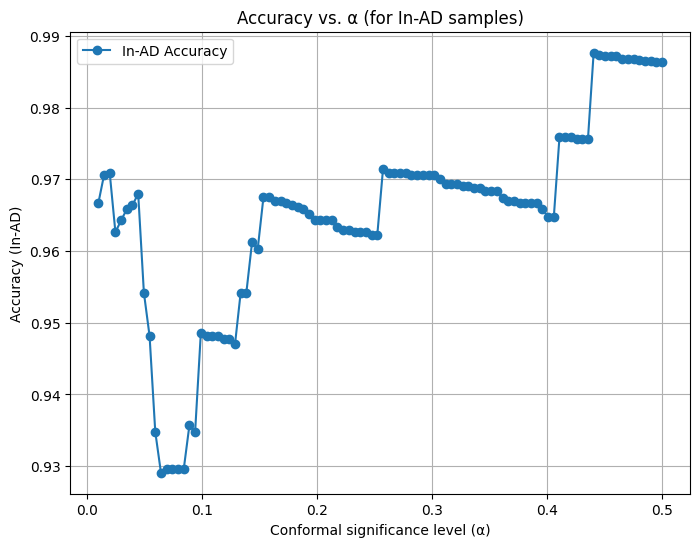

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier  # 虽然没用上，可保留
from mapie.classification import MapieClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 2. 训练一个用于预测标签的 XGB 基模型（这里是 RF）
base_proba = RandomForestClassifier(
        n_estimators=145,       # 可根据需要调节
        max_depth=44,           # 可调整，或设为 None
        min_samples_split=0.021984640895660577,
        random_state=42,
        n_jobs=-1               # 并行加速
    )
base_proba.fit(X_train, y_train)
y_pred = base_proba.predict(X_test)  # 预测标签

# 3. 用 MAPIE 包装做 conformal calibration
mapie = MapieClassifier(
    estimator=RandomForestClassifier(
        n_estimators=972,
        max_depth=1,
        min_samples_split=0.16565974359545876,
        random_state=42,
        n_jobs=-1
    ),
    method="score",
    cv=StratifiedKFold(5, shuffle=True, random_state=42)
)
mapie.fit(X_train, y_train)

# 4. α 扫描，并在 In-AD 样本上计算 Accuracy
alphas = np.linspace(0.01, 0.5, 100)
results = []
for alpha in alphas:
    preds, ps = mapie.predict(X_test, alpha=alpha)
    
    in_ad_mask = ((ps > alpha).sum(axis=1) == 1).ravel()
    n_in = in_ad_mask.sum()
    if n_in < 5:
        continue

    y_true_in = np.array(y_test)[in_ad_mask]
    y_pred_in = np.array(preds)[in_ad_mask]
    
    if len(np.unique(y_true_in)) == 2:
        acc_in = accuracy_score(y_true_in, y_pred_in)
    else:
        acc_in = np.nan

    results.append((alpha, n_in, acc_in))

# 5. 打印表格
print(f"{'alpha':>6s}  {'#In-AD':>6s}  {'ACC(In-AD)':>12s}")
for alpha, n_in, acc_in in results:
    print(f"{alpha:6.3f}  {n_in:6d}  {acc_in:12.4f}")

# 6. 绘制 α vs ACC 曲线
alphas_plot = [r[0] for r in results]
accs_plot   = [r[2] for r in results]

plt.figure(figsize=(8, 6))
plt.plot(alphas_plot, accs_plot, '-o', label='In-AD Accuracy')
plt.xlabel("Conformal significance level (α)")
plt.ylabel("Accuracy (In-AD)")
plt.title("Accuracy vs. α (for In-AD samples)")
plt.grid(True)
plt.legend()
plt.show()



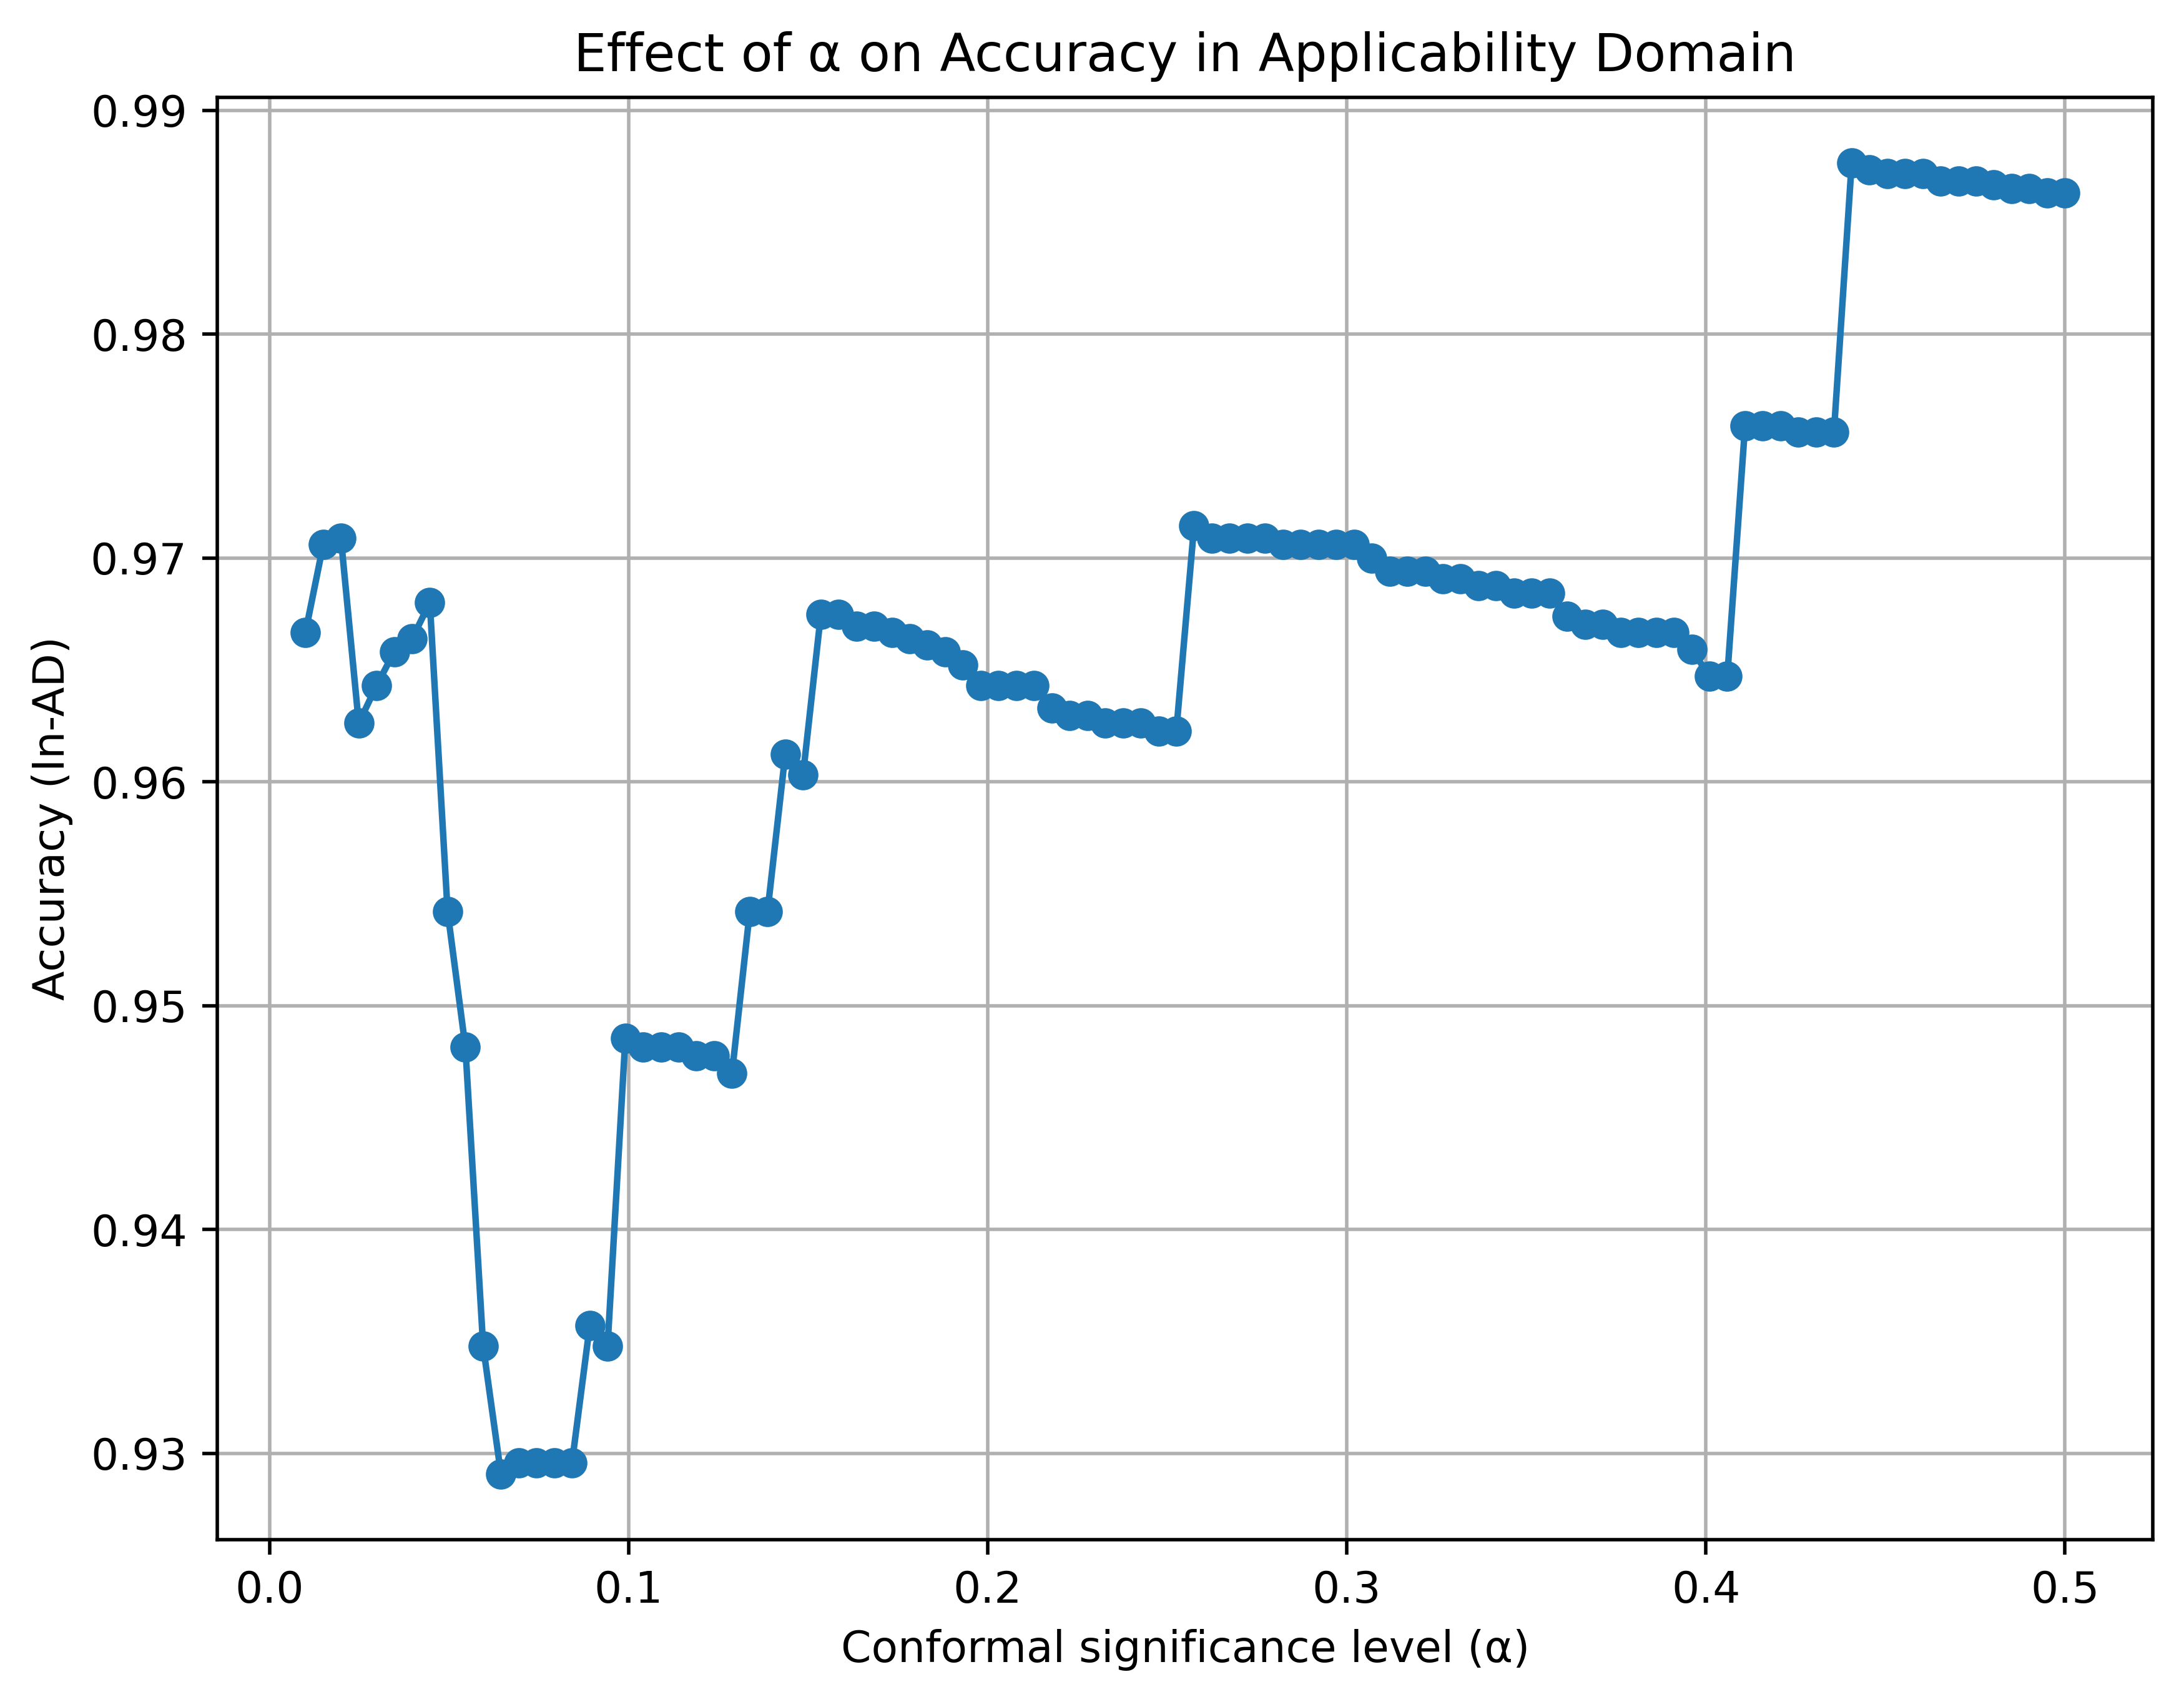

In [4]:
plt.figure(figsize=(8, 6), dpi=500) 
plt.plot(alphas_plot, accs_plot, marker='o', label='In-AD Accuracy')
plt.xlabel("Conformal significance level (α)")
plt.ylabel("Accuracy (In-AD)")
plt.title("Effect of α on Accuracy in Applicability Domain")

plt.grid(True)
plt.show()


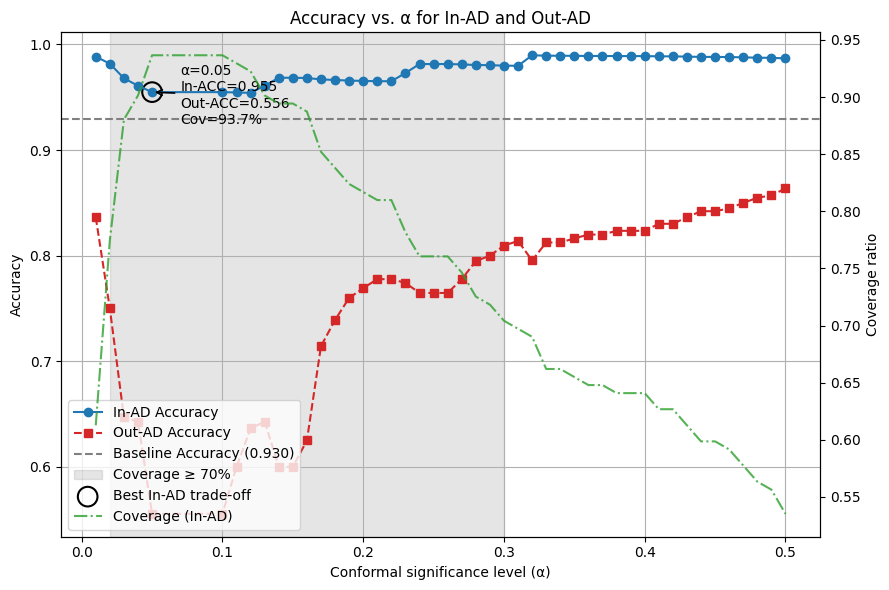

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from mapie.classification import MapieClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 1. 拟合基模型并获取预测结果与 baseline Accuracy
base = RandomForestClassifier(
        n_estimators=145,       # 可根据需要调节
        max_depth=44,           # 可调整，或设为 None
        min_samples_split=0.021984640895660577,
        random_state=42,
        n_jobs=-1               # 并行加速
    )
base.fit(X_train, y_train)
y_pred = base.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# 2. MAPIE 校准器
mapie = MapieClassifier(
    estimator=base, 
    method="score",
    cv=StratifiedKFold(5, shuffle=True, random_state=42)
)
mapie.fit(X_train, y_train)

# 3. 扫描 α，计算 In-AD/Out-AD 的 Accuracy 和覆盖率
alphas = np.linspace(0.01, 0.5, 50)
records = []
for α in alphas:
    preds, ps = mapie.predict(X_test, alpha=α)
    mask_in  = ((ps > α).sum(1) == 1).ravel()
    mask_out = ~mask_in
    n_in  = mask_in.sum()
    n_out = mask_out.sum()
    cov = n_in / len(y_test)
    if n_in < 5 or n_out < 5:
        continue
    acc_in  = accuracy_score(y_test[mask_in], preds[mask_in])
    acc_out = accuracy_score(y_test[mask_out], preds[mask_out])
    records.append((α, cov, acc_in, acc_out))

αs, covs, acc_ins, acc_outs = map(np.array, zip(*records))

# 4. 找到“最佳 trade-off”点（示例：acc_in * cov 最大）
scores = acc_ins * covs
best = np.argmax(scores)
α_best, cov_best, acc_in_best, acc_out_best = αs[best], covs[best], acc_ins[best], acc_outs[best]

# 5. 计算覆盖率 ≥ min_cov 时的 α 区间
min_cov = 0.70
mask_cov70 = covs >= min_cov
α_min70, α_max70 = αs[mask_cov70].min(), αs[mask_cov70].max()

# 6. 绘图
fig, ax1 = plt.subplots(figsize=(9, 6))

# In-AD 和 Out-AD Accuracy
ax1.plot(αs, acc_ins,  '-o', label='In-AD Accuracy',  color='tab:blue')
ax1.plot(αs, acc_outs, '--s', label='Out-AD Accuracy', color='tab:red')

# baseline
ax1.axhline(baseline_acc, color='gray', linestyle='--',
            label=f'Baseline Accuracy ({baseline_acc:.3f})')

ax1.set_xlabel("Conformal significance level (α)")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy vs. α for In-AD and Out-AD")
ax1.grid(True)

# 高亮覆盖率 ≥ min_cov 时的 α 区间
ax1.axvspan(α_min70, α_max70, color='gray', alpha=0.2,
            label=f"Coverage ≥ {int(min_cov*100)}%")

# 标注最佳 trade-off 点
ax1.scatter(α_best, acc_ins[best], s=200, facecolors='none',
            edgecolors='black', linewidths=1.5, label='Best In-AD trade-off')
ax1.annotate(
    f"α={α_best:.2f}\nIn-ACC={acc_in_best:.3f}\nOut-ACC={acc_out_best:.3f}\nCov={cov_best:.1%}",
    xy=(α_best, acc_ins[best]),
    xytext=(α_best+0.02, acc_ins[best]-0.03),
    arrowprops=dict(arrowstyle="->", lw=1.2)
)

# 次坐标轴：Coverage
ax2 = ax1.twinx()
ax2.plot(αs, covs, '-.', color='tab:green', alpha=0.8, label='Coverage (In-AD)')
ax2.set_ylabel("Coverage ratio")

# 合并图例
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower left')

plt.tight_layout()
plt.show()


In [6]:
# 假设你已用这段代码收集了有效的点：
records = []  # 每项为 (α, coverage, acc_in, acc_out)
for α in alphas:
    # ...你的逻辑略过 In-AD 样本太少的 α
    records.append((α, coverage, acc_in, acc_out))

# 拆分为等长数组
αs, coverages, acc_ins, acc_outs = map(np.array, zip(*records))

# 现在 coverages 和 acc_ins 长度一致，可以计算最优指标
scores = coverages * acc_ins
best_idx = np.argmax(scores)

# 最优指标点
α_opt   = αs[best_idx]
cov_opt = coverages[best_idx]
acc_opt = acc_ins[best_idx]

print(f"Optimal α = {α_opt:.3f}")
print(f"Coverage = {cov_opt:.1%}")
print(f"In-AD Accuracy = {acc_opt:.3f}")



NameError: name 'coverage' is not defined

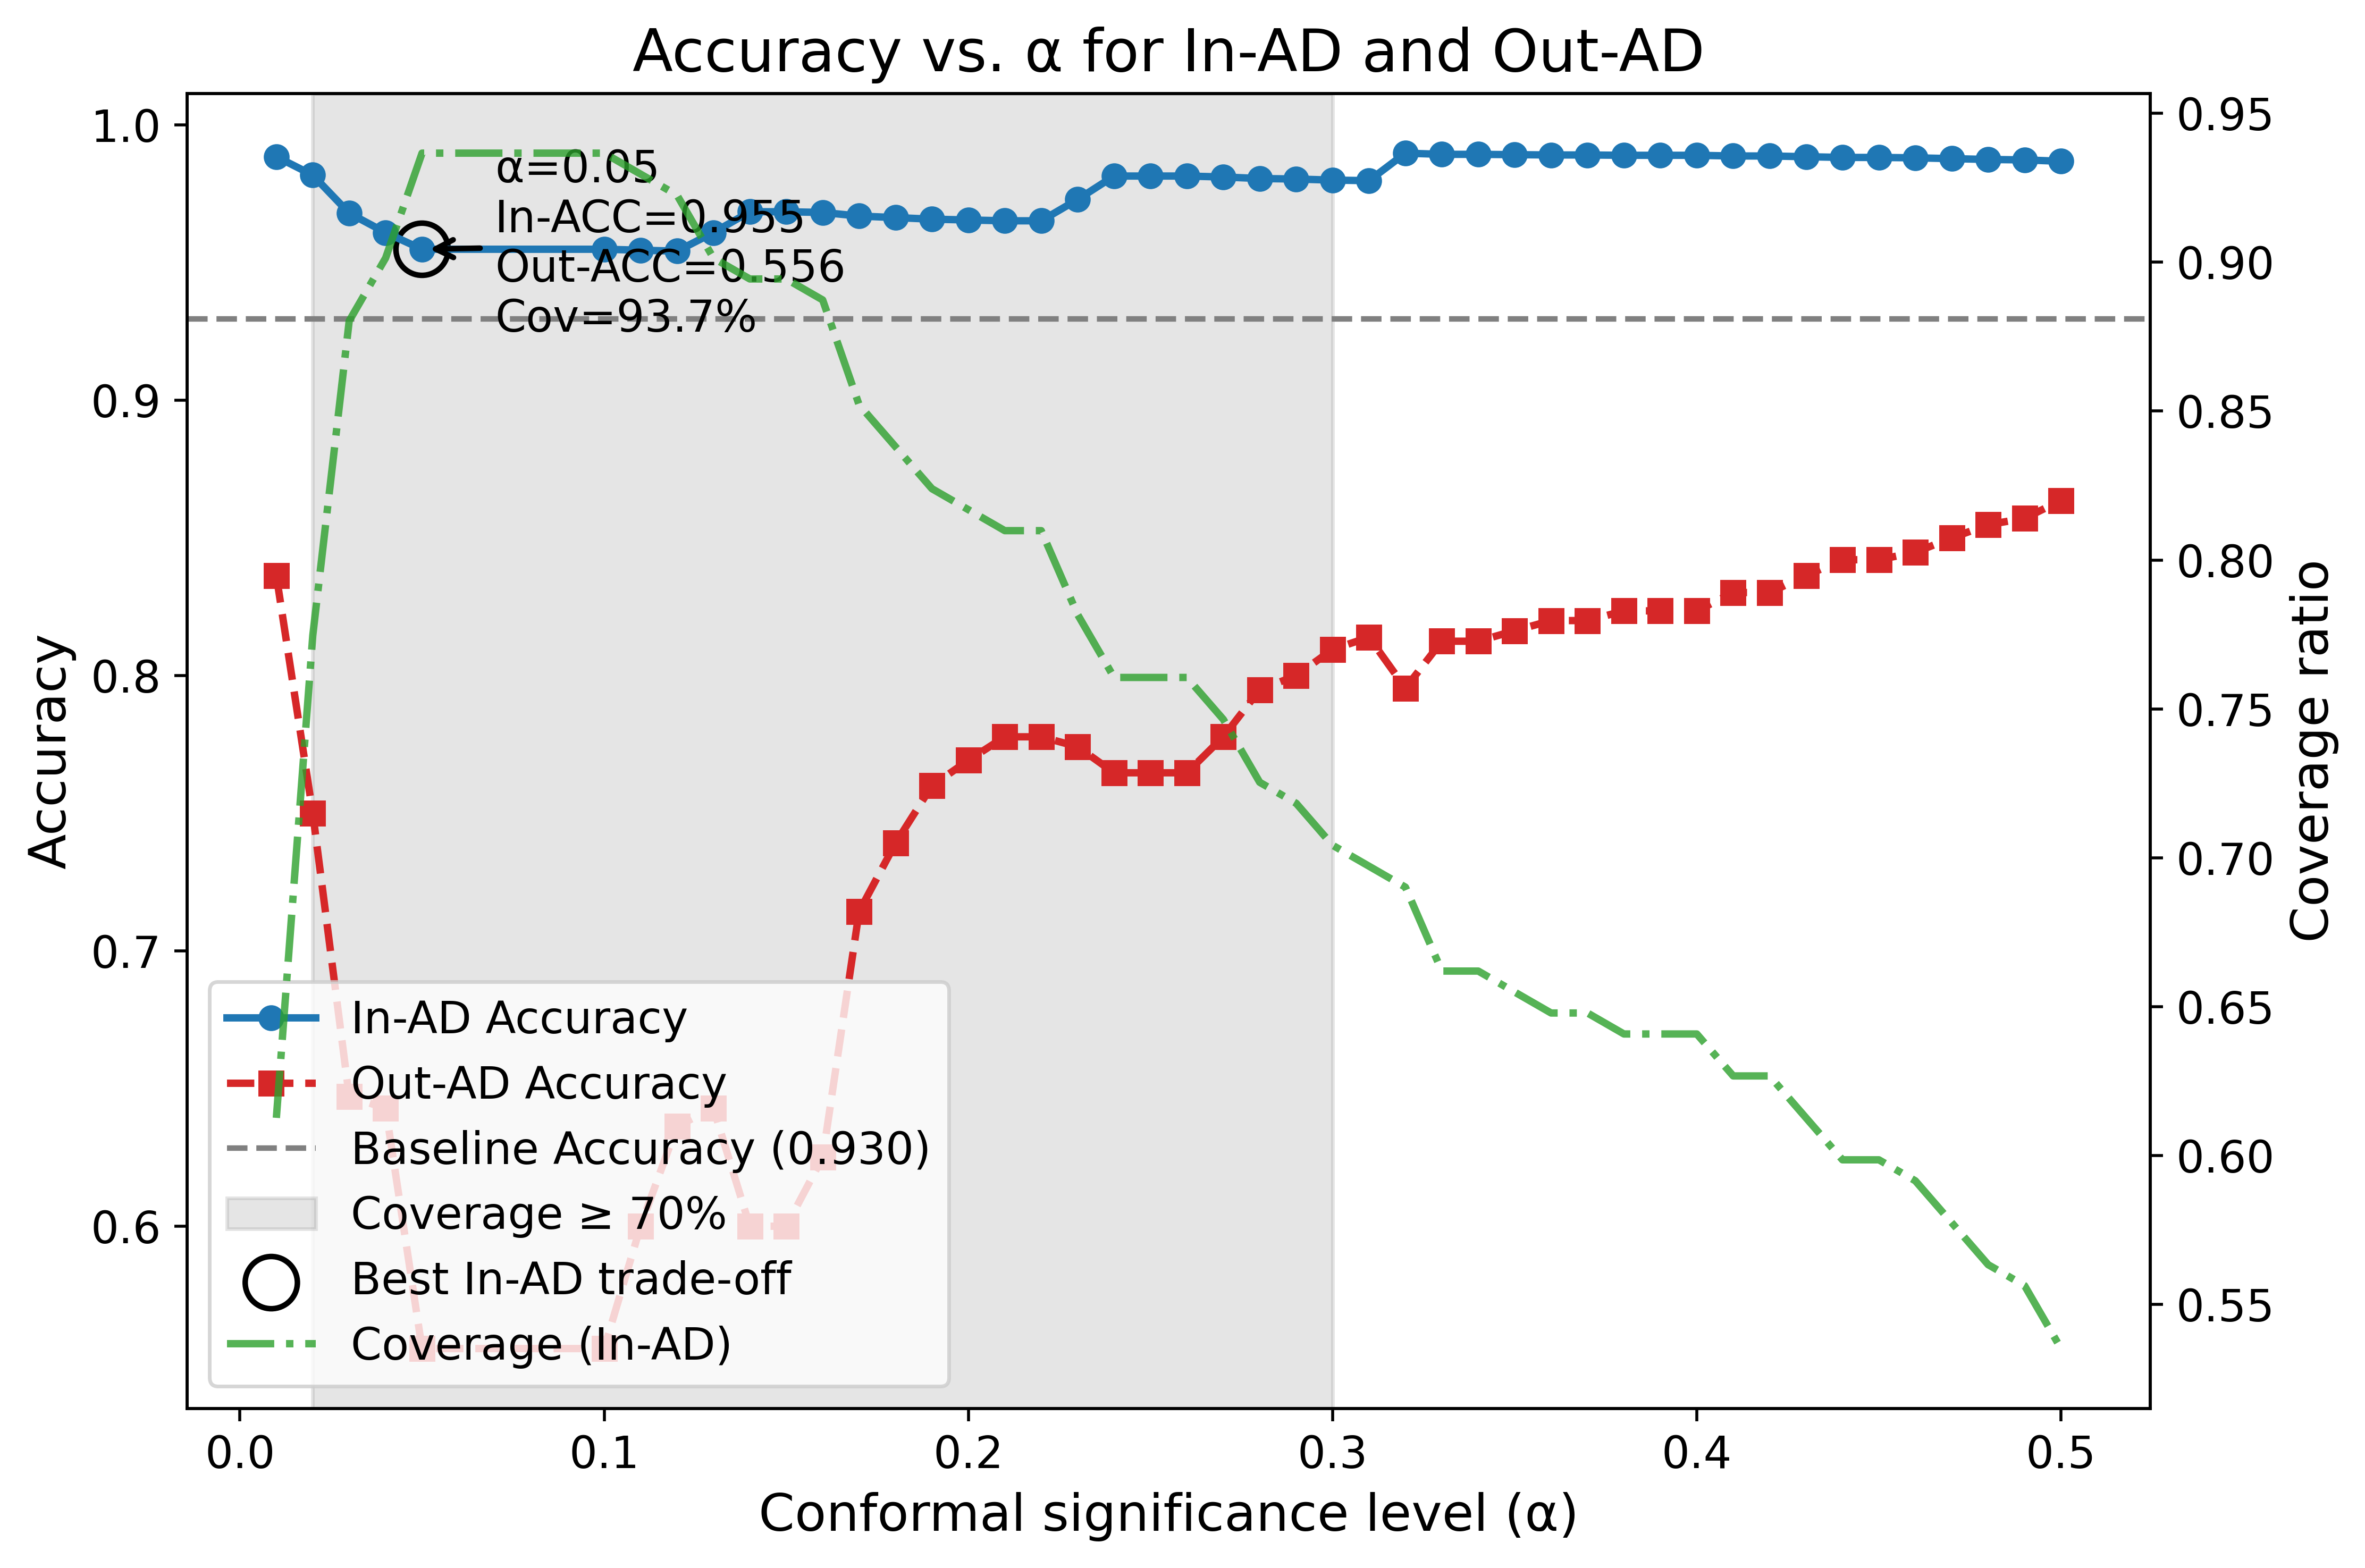

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from mapie.classification import MapieClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# 1. 拟合基模型并获取预测结果与 baseline Accuracy
base = RandomForestClassifier(
        n_estimators=145,       # 可根据需要调节
        max_depth=44,           # 可调整，或设为 None
        min_samples_split=0.021984640895660577,
        random_state=42,
        n_jobs=-1               # 并行加速
    )
base.fit(X_train, y_train)
y_pred = base.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# 2. MAPIE 校准器
mapie = MapieClassifier(
    estimator=base, 
    method="score",
    cv=StratifiedKFold(5, shuffle=True, random_state=42)
)
mapie.fit(X_train, y_train)

# 3. 扫描 α，计算 In-AD/Out-AD 的 Accuracy 和覆盖率
alphas = np.linspace(0.01, 0.5, 50)
records = []
for α in alphas:
    preds, ps = mapie.predict(X_test, alpha=α)
    mask_in  = ((ps > α).sum(1) == 1).ravel()
    mask_out = ~mask_in
    n_in  = mask_in.sum()
    n_out = mask_out.sum()
    cov = n_in / len(y_test)
    if n_in < 5 or n_out < 5:
        continue
    acc_in  = accuracy_score(y_test[mask_in], preds[mask_in])
    acc_out = accuracy_score(y_test[mask_out], preds[mask_out])
    records.append((α, cov, acc_in, acc_out))

αs, covs, acc_ins, acc_outs = map(np.array, zip(*records))

# 4. 找到“最佳 trade-off”点（这里示例用：acc_in*cov 最大）
scores = acc_ins * covs
best = np.argmax(scores)
α_best, cov_best, acc_in_best, acc_out_best = αs[best], covs[best], acc_ins[best], acc_outs[best]

# 5. 如果你希望保证至少 70% 覆盖率时的 α 范围
min_cov = 0.70
mask_cov70 = covs >= min_cov
α_min70, α_max70 = αs[mask_cov70].min(), αs[mask_cov70].max()

# 6. 绘图（优化版）
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=500)

# In-AD 和 Out-AD Accuracy
ax1.plot(αs, acc_ins,  '-o', label='In-AD Accuracy',  color='tab:blue', markersize=6, linewidth=2)
ax1.plot(αs, acc_outs,'--s', label='Out-AD Accuracy', color='tab:red',  markersize=6, linewidth=2)
# baseline
ax1.axhline(baseline_acc, color='gray', linestyle='--', linewidth=1.5,
            label=f'Baseline Accuracy ({baseline_acc:.3f})')

# 坐标轴标签
ax1.set_xlabel("Conformal significance level (α)", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=14)
ax1.set_title("Accuracy vs. α for In-AD and Out-AD", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)

# 高亮覆盖率 ≥ min_cov 时的 α 区间
ax1.axvspan(α_min70, α_max70, color='gray', alpha=0.2,
            label=f"Coverage ≥ {int(min_cov*100)}%")

# 标注最佳 trade-off 点
ax1.scatter(α_best, acc_ins[best], s=200, facecolors='none',
            edgecolors='black', linewidths=1.5, label='Best In-AD trade-off')
ax1.annotate(
    f"α={α_best:.2f}\nIn-ACC={acc_in_best:.3f}\nOut-ACC={acc_out_best:.3f}\nCov={cov_best:.1%}",
    xy=(α_best, acc_ins[best]),
    xytext=(α_best+0.02, acc_ins[best]-0.03),
    fontsize=12,
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# 次坐标轴：Coverage
ax2 = ax1.twinx()
ax2.plot(αs, covs, '-.', color='tab:green', alpha=0.8, label='Coverage (In-AD)', linewidth=2)
ax2.set_ylabel("Coverage ratio", fontsize=14)
ax2.tick_params(axis='y', labelsize=12)

# 合并图例并增大字体
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=12, frameon=True)

plt.tight_layout()
plt.show()


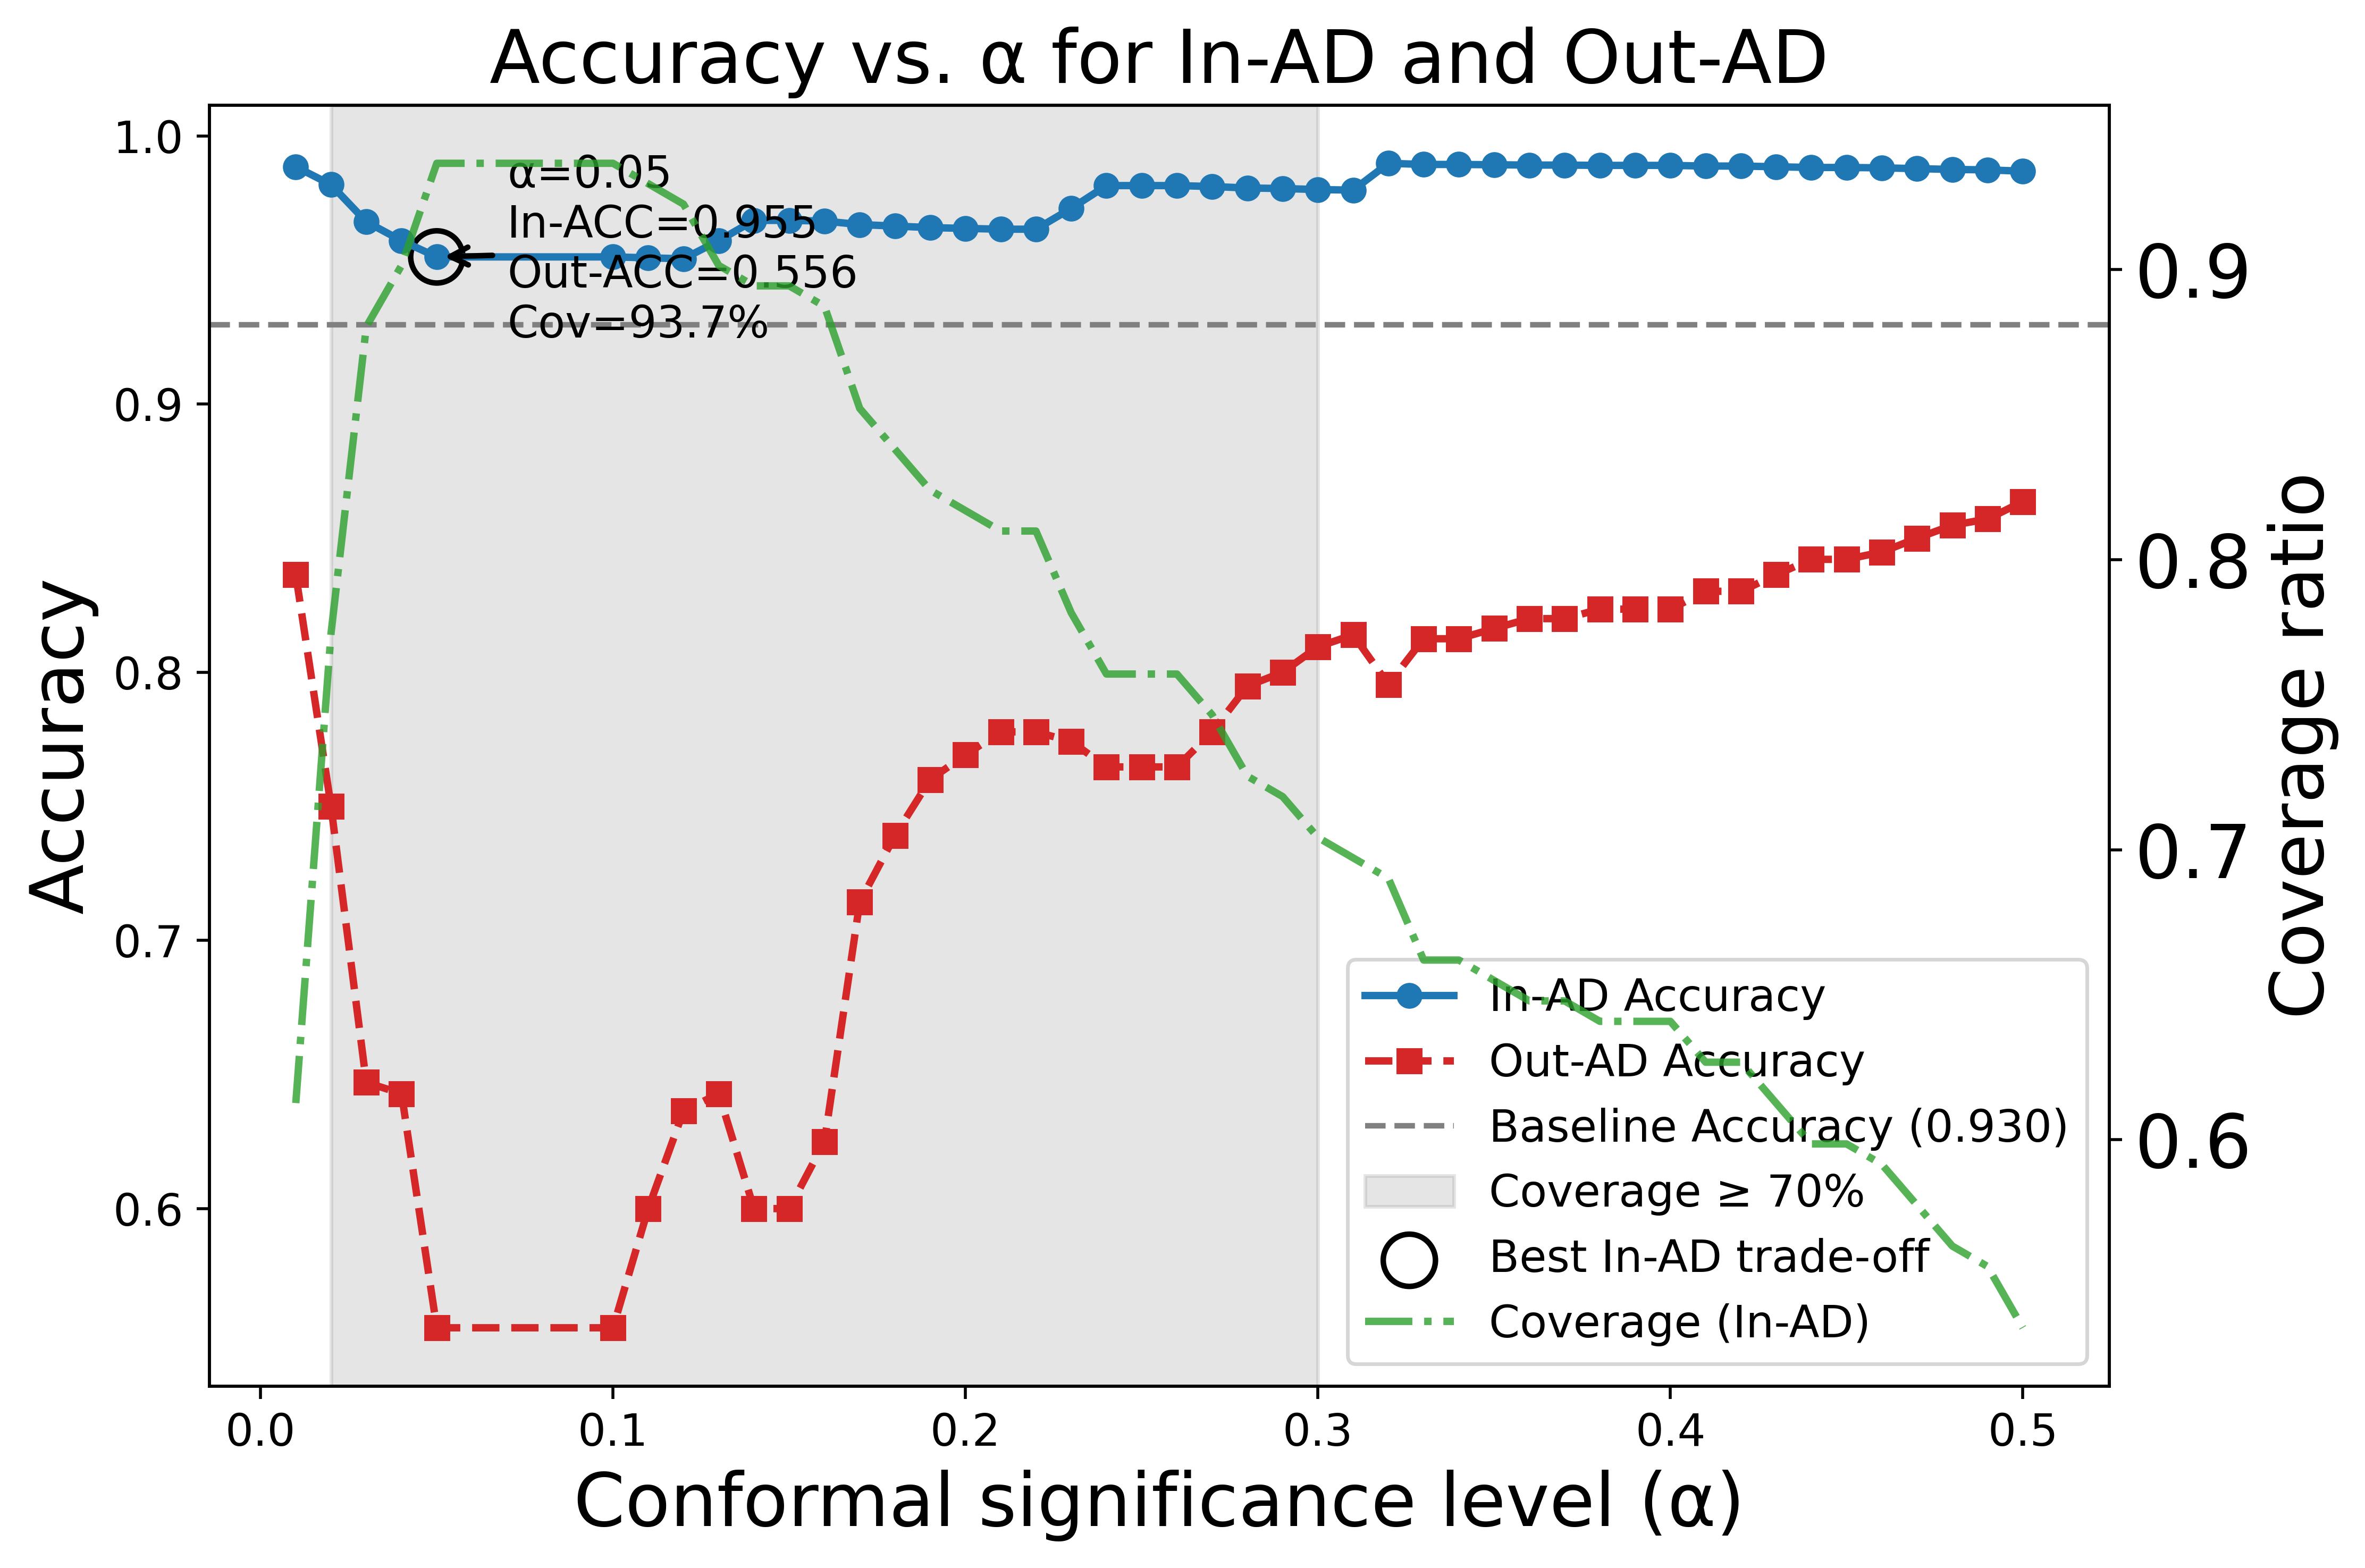

In [8]:
# 6. 绘图（优化版，Accuracy）
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=500)  # 提高 DPI

# In-AD 和 Out-AD Accuracy
ax1.plot(αs, acc_ins,  '-o', label='In-AD Accuracy',  color='tab:blue', markersize=6, linewidth=2)
ax1.plot(αs, acc_outs,'--s', label='Out-AD Accuracy', color='tab:red',  markersize=6, linewidth=2)

# baseline accuracy
ax1.axhline(baseline_acc, color='gray', linestyle='--', linewidth=1.5,
            label=f'Baseline Accuracy ({baseline_acc:.3f})')

# 坐标轴标签
ax1.set_xlabel("Conformal significance level (α)", fontsize=20)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.set_title("Accuracy vs. α for In-AD and Out-AD", fontsize=20)

# 增大刻度字体
ax1.tick_params(axis='both', which='major', labelsize=12)

# 高亮覆盖率 ≥ min_cov 时的 α 区间
ax1.axvspan(α_min70, α_max70, color='gray', alpha=0.2,
            label=f"Coverage ≥ {int(min_cov*100)}%")

# 标注最佳 trade-off 点
ax1.scatter(α_best, acc_ins[best], s=200, facecolors='none',
            edgecolors='black', linewidths=1.5, label='Best In-AD trade-off')
ax1.annotate(
    f"α={α_best:.2f}\nIn-ACC={acc_in_best:.3f}\nOut-ACC={acc_out_best:.3f}\nCov={cov_best:.1%}",
    xy=(α_best, acc_ins[best]),
    xytext=(α_best+0.02, acc_ins[best]-0.03),
    fontsize=12,
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# 次坐标轴：Coverage
ax2 = ax1.twinx()
ax2.plot(αs, covs, '-.', color='tab:green', alpha=0.8, label='Coverage (In-AD)', linewidth=2)
ax2.set_ylabel("Coverage ratio", fontsize=20)
ax2.tick_params(axis='y', labelsize=20)

# 合并图例并增大字体
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right', fontsize=12, frameon=True)

plt.tight_layout()
plt.show()


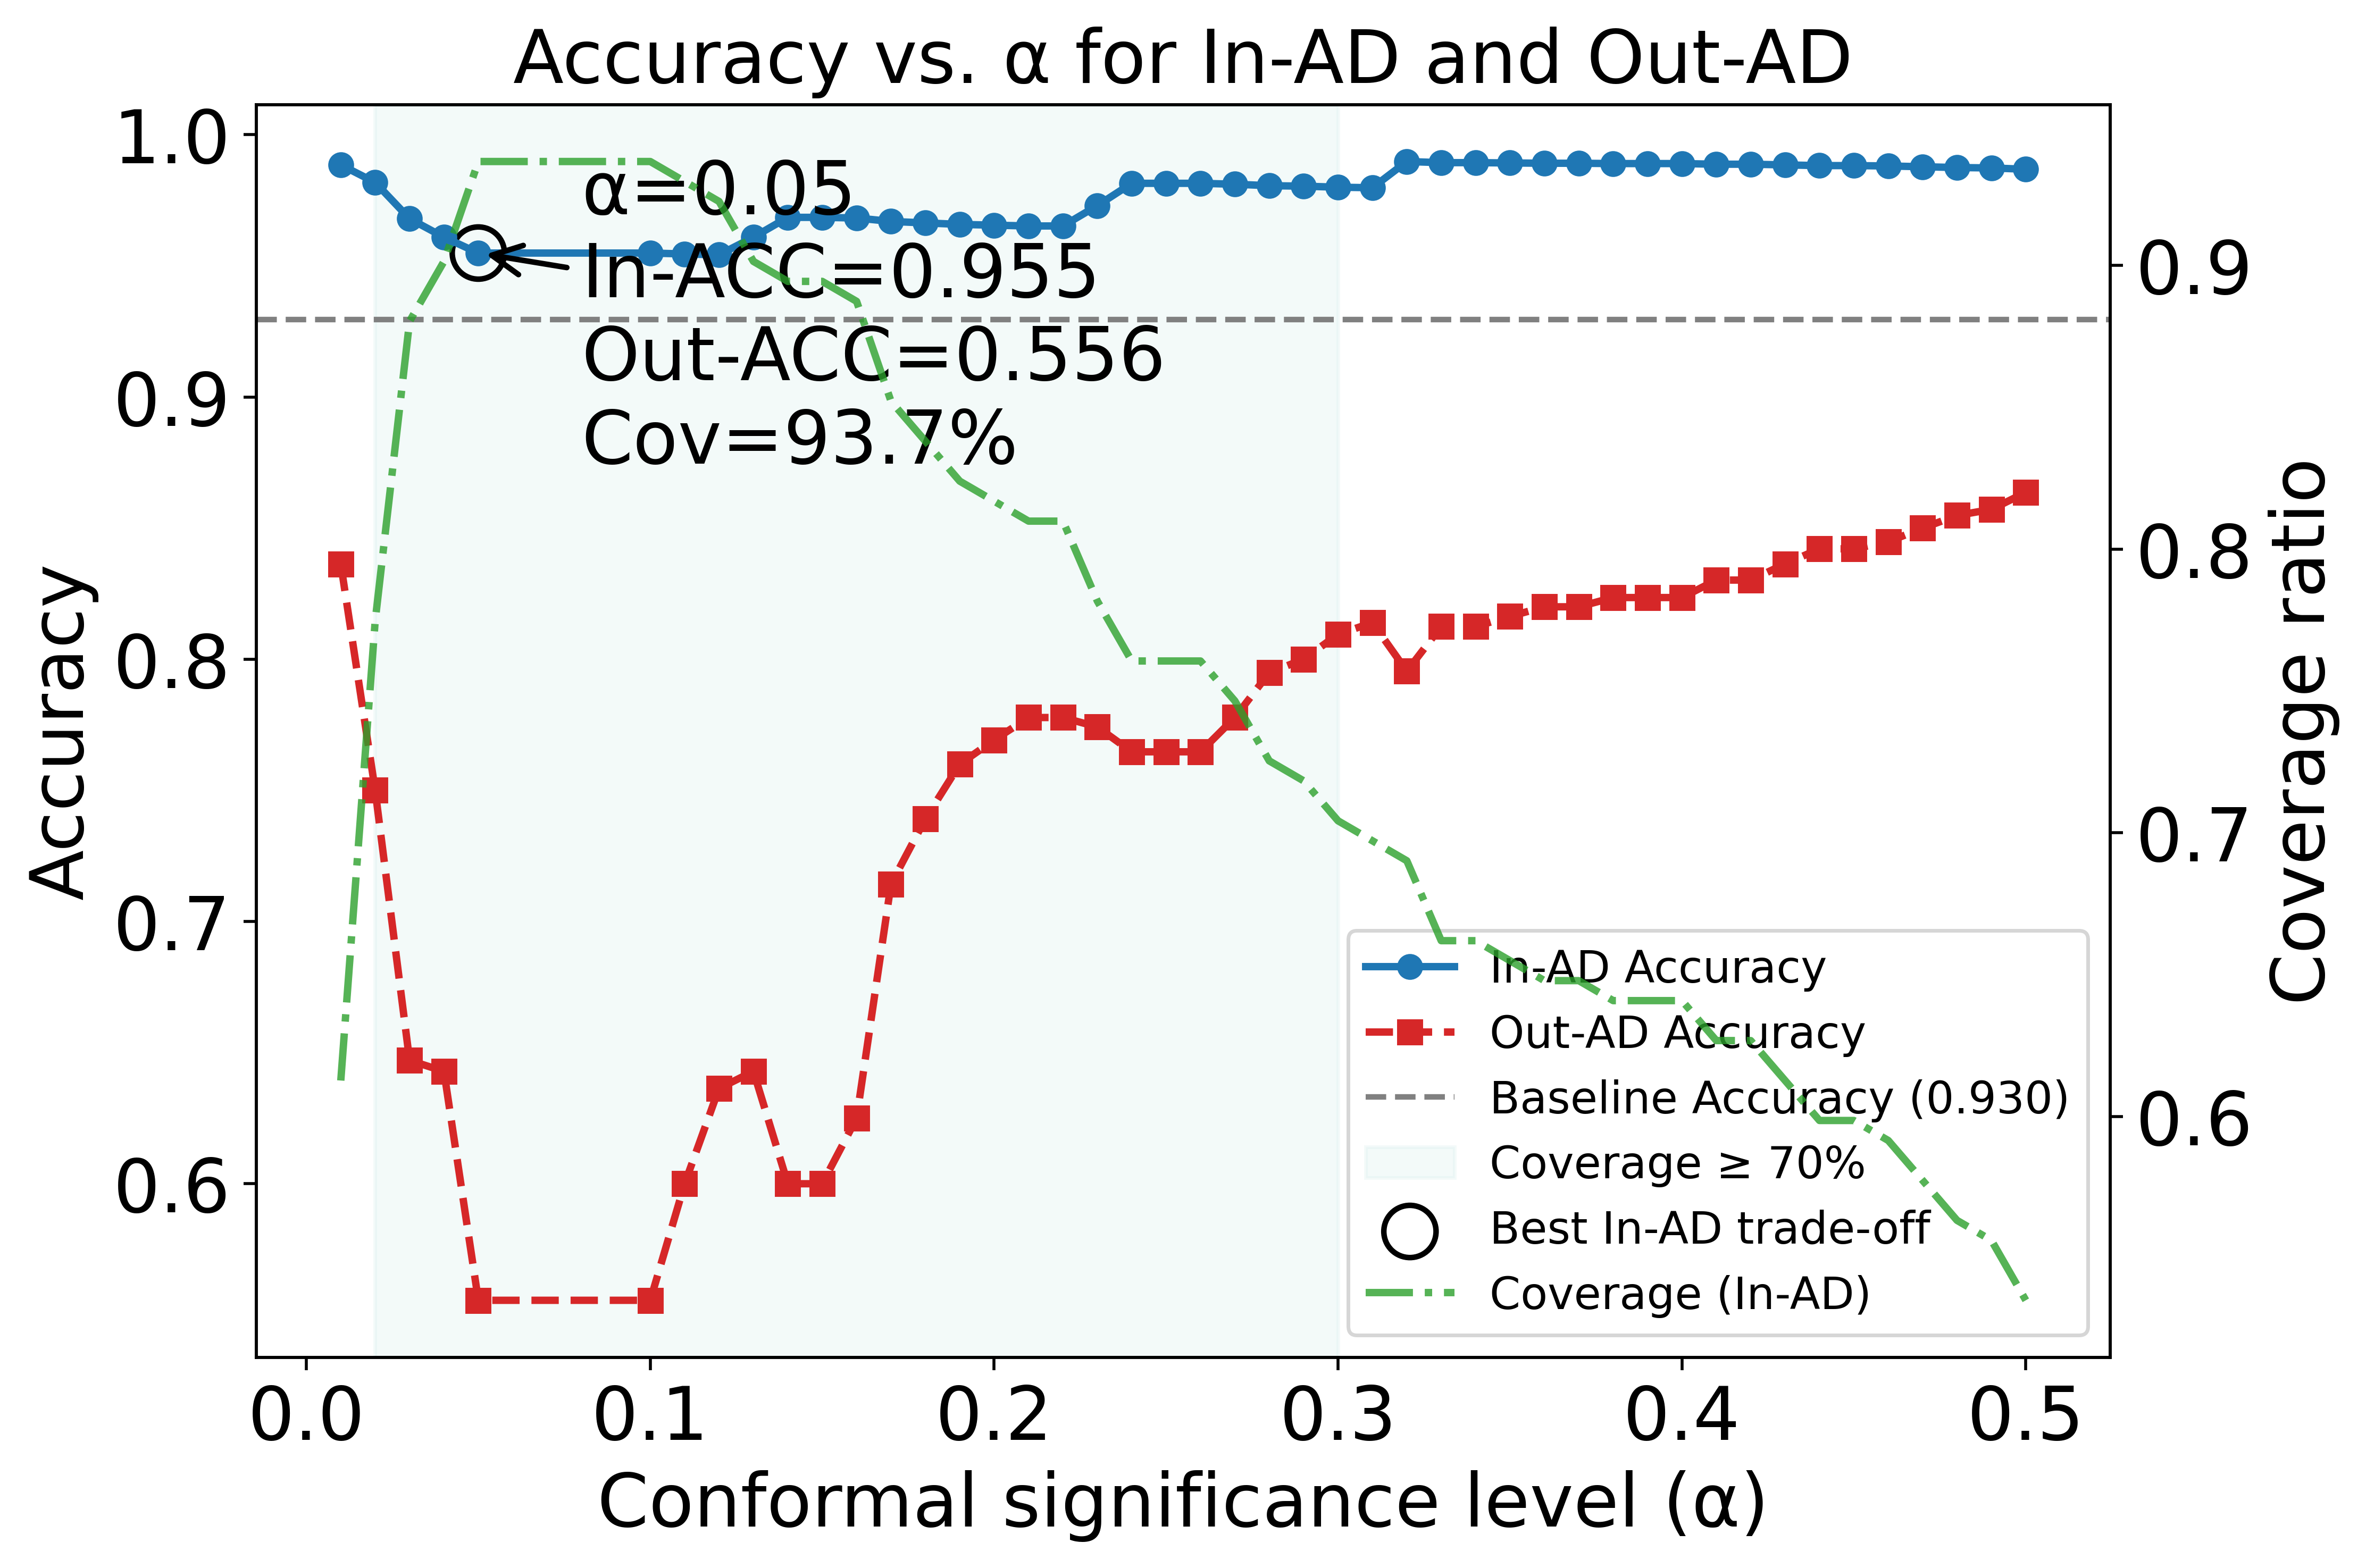

In [10]:
# 6. 绘图（优化版：Accuracy）
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=500)  # 提高 DPI

# In-AD 和 Out-AD Accuracy 曲线
ax1.plot(αs, acc_ins,  '-o', label='In-AD Accuracy',  color='tab:blue', markersize=6, linewidth=2)
ax1.plot(αs, acc_outs,'--s', label='Out-AD Accuracy', color='tab:red',  markersize=6, linewidth=2)

# baseline Accuracy
ax1.axhline(baseline_acc, color='gray', linestyle='--', linewidth=1.5,
            label=f'Baseline Accuracy ({baseline_acc:.3f})')

# 坐标轴标签与标题
ax1.set_xlabel("Conformal significance level (α)", fontsize=20)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.set_title("Accuracy vs. α for In-AD and Out-AD", fontsize=20)

# 增大刻度字体
ax1.tick_params(axis='both', which='major', labelsize=20)

# 高亮覆盖率 ≥ min_cov 时的 α 区间
ax1.axvspan(α_min70, α_max70, color='#C7E6E5', alpha=0.2,
            label=f"Coverage ≥ {int(min_cov*100)}%")

# 标注最佳 trade-off 点
ax1.scatter(α_best, acc_ins[best], s=200, facecolors='none',
            edgecolors='black', linewidths=1.5, label='Best In-AD trade-off')
ax1.annotate(
    f"α={α_best:.2f}\nIn-ACC={acc_in_best:.3f}\nOut-ACC={acc_out_best:.3f}\nCov={cov_best:.1%}",
    xy=(α_best, acc_ins[best]),
    xytext=(α_best+0.03, acc_ins[best]-0.08),
    fontsize=20,
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# 次坐标轴：Coverage
ax2 = ax1.twinx()
ax2.plot(αs, covs, '-.', color='tab:green', alpha=0.8, label='Coverage (In-AD)', linewidth=2)
ax2.set_ylabel("Coverage ratio", fontsize=20)
ax2.tick_params(axis='y', labelsize=20)

# 合并图例
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower right', fontsize=12, frameon=True)

plt.tight_layout()
plt.show()

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
# plt.rcParams['xtick.labelsize'] = 20
# plt.rcParams['ytick.labelsize'] = 20

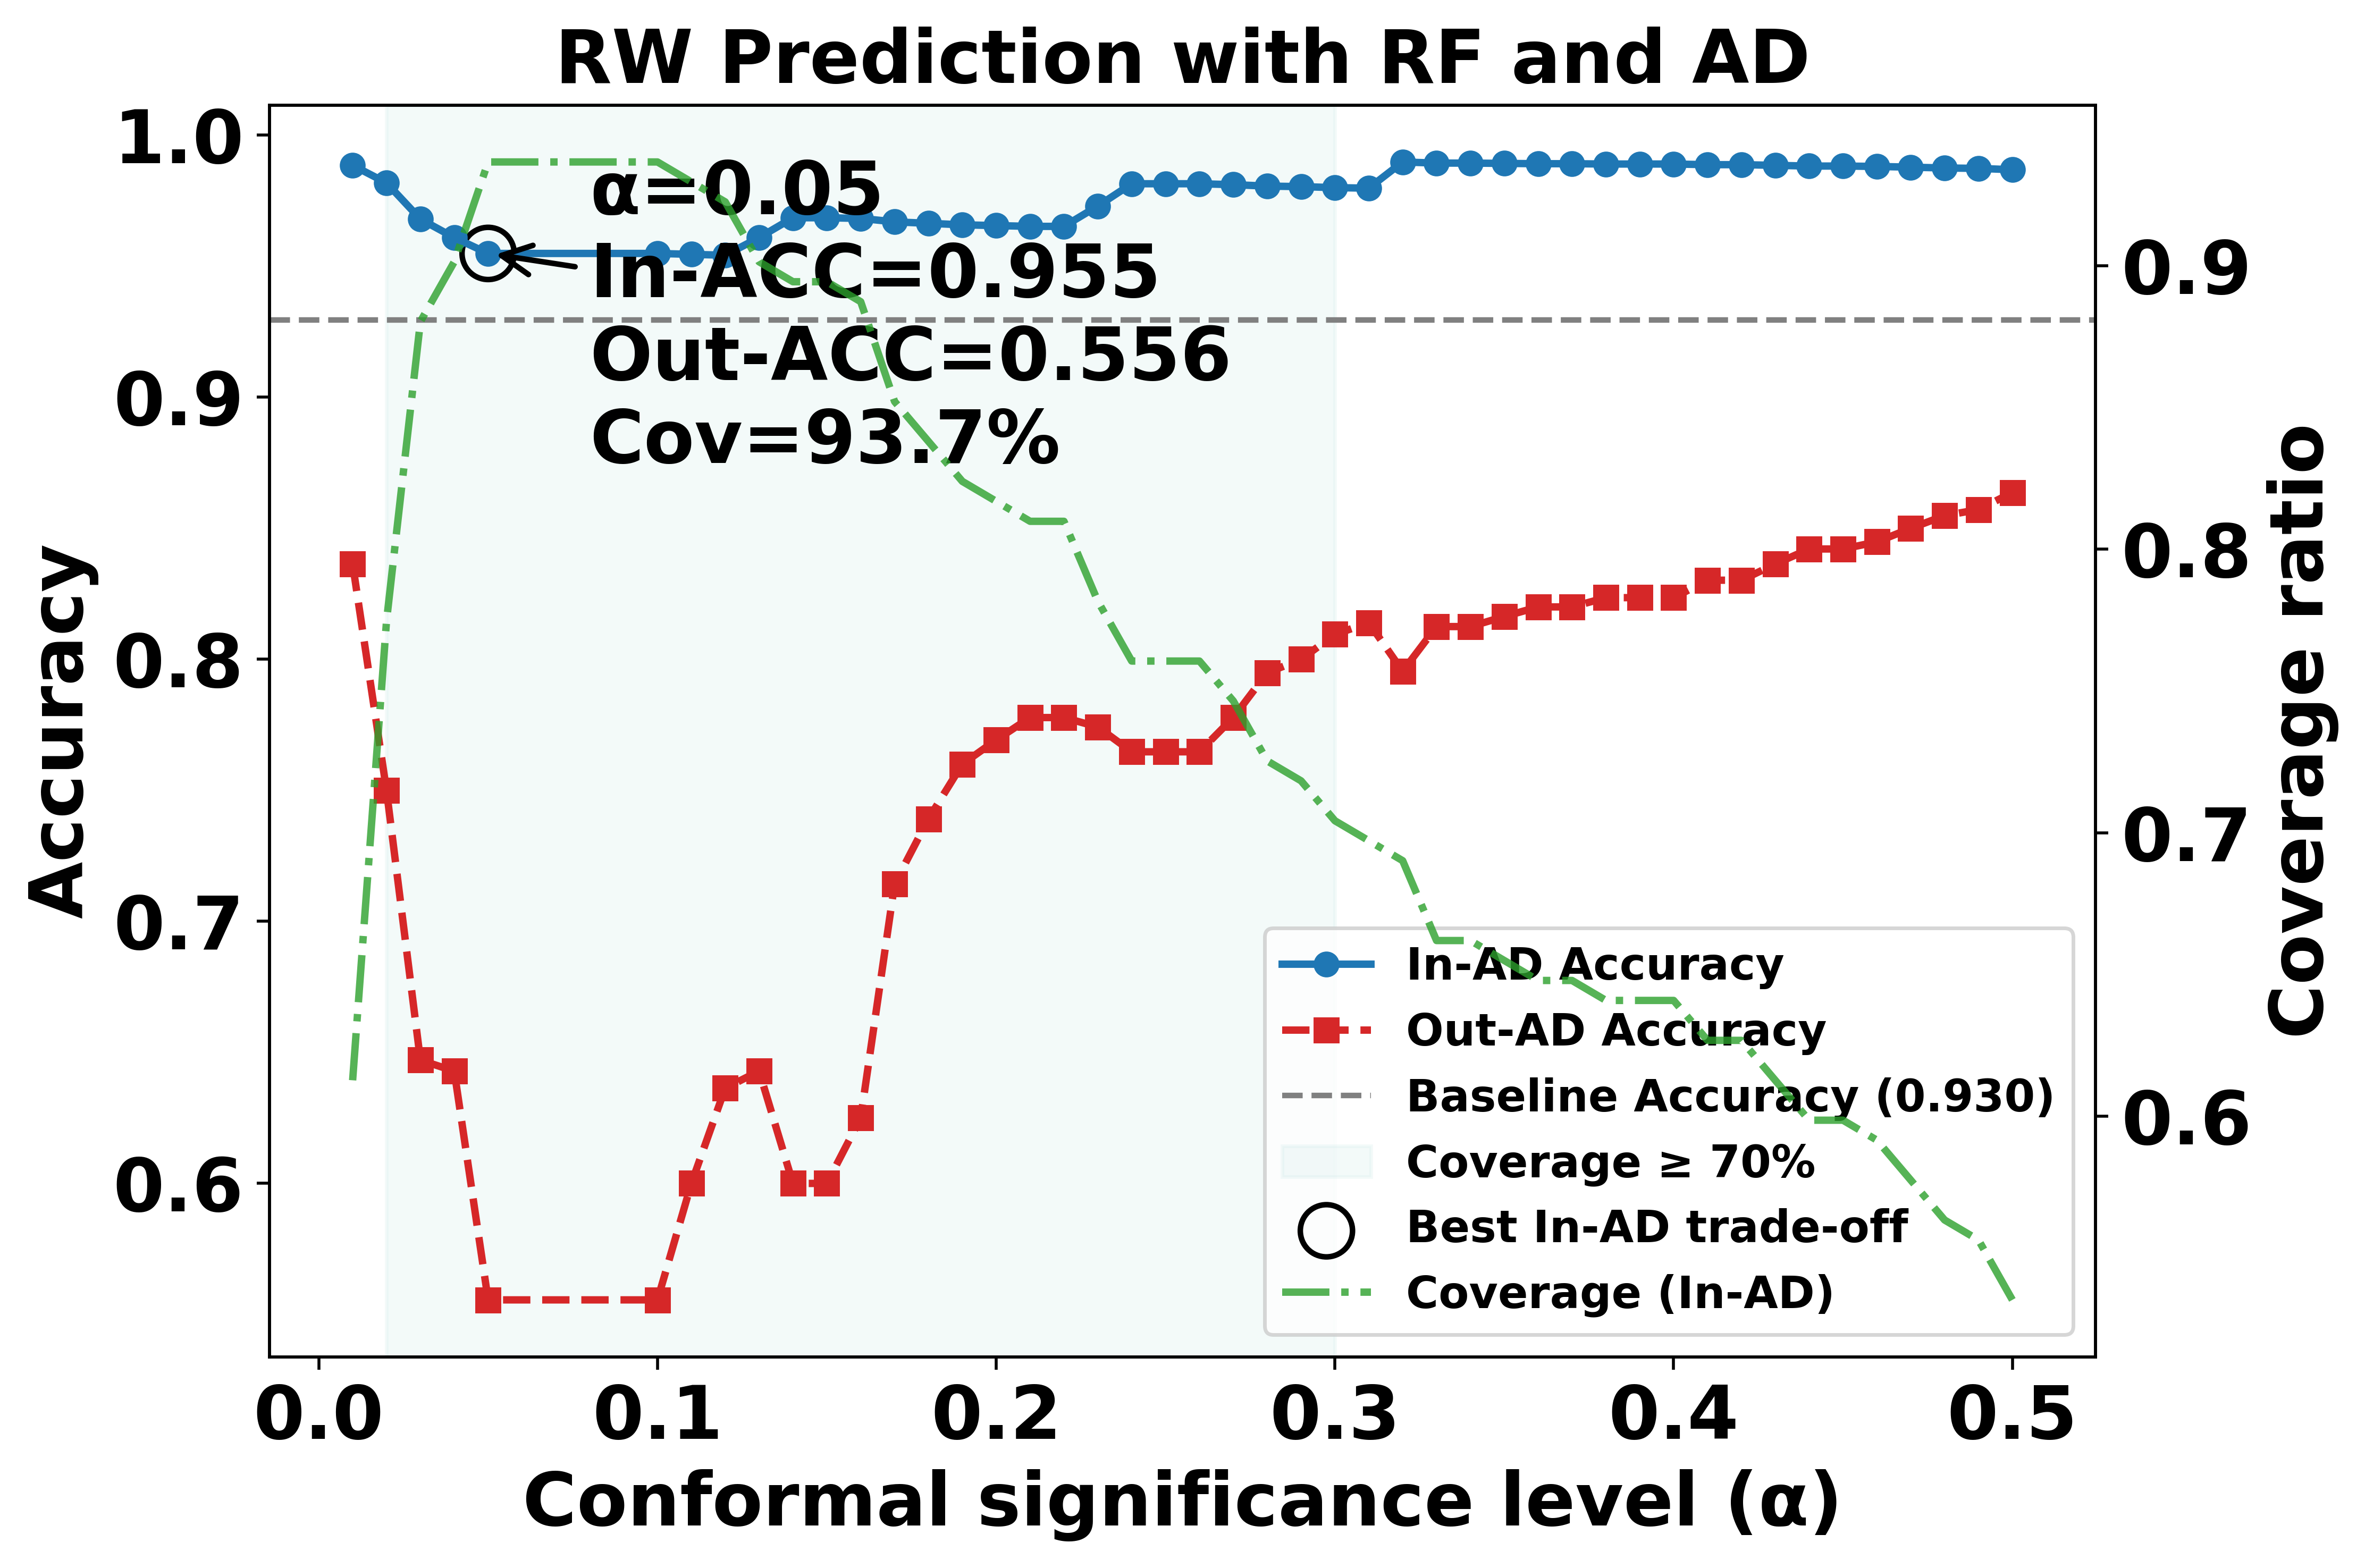

In [12]:
# 6. 绘图（优化版：Accuracy）
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=500)  # 提高 DPI

# In-AD 和 Out-AD Accuracy 曲线
ax1.plot(αs, acc_ins,  '-o', label='In-AD Accuracy',  color='tab:blue', markersize=6, linewidth=2)
ax1.plot(αs, acc_outs,'--s', label='Out-AD Accuracy', color='tab:red',  markersize=6, linewidth=2)

# baseline Accuracy
ax1.axhline(baseline_acc, color='gray', linestyle='--', linewidth=1.5,
            label=f'Baseline Accuracy ({baseline_acc:.3f})')

# 坐标轴标签与标题
ax1.set_xlabel("Conformal significance level (α)", fontsize=20)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.set_title("RW Prediction with RF and AD", fontsize=20)

# 增大刻度字体
ax1.tick_params(axis='both', which='major', labelsize=20)

# 高亮覆盖率 ≥ min_cov 时的 α 区间
ax1.axvspan(α_min70, α_max70, color='#C7E6E5', alpha=0.2,
            label=f"Coverage ≥ {int(min_cov*100)}%")

# 标注最佳 trade-off 点
ax1.scatter(α_best, acc_ins[best], s=200, facecolors='none',
            edgecolors='black', linewidths=1.5, label='Best In-AD trade-off')
ax1.annotate(
    f"α={α_best:.2f}\nIn-ACC={acc_in_best:.3f}\nOut-ACC={acc_out_best:.3f}\nCov={cov_best:.1%}",
    xy=(α_best, acc_ins[best]),
    xytext=(α_best+0.03, acc_ins[best]-0.08),
    fontsize=20,
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# 次坐标轴：Coverage
ax2 = ax1.twinx()
ax2.plot(αs, covs, '-.', color='tab:green', alpha=0.8, label='Coverage (In-AD)', linewidth=2)
ax2.set_ylabel("Coverage ratio", fontsize=20)
ax2.tick_params(axis='y', labelsize=20)

# 合并图例
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower right', fontsize=12, frameon=True)

plt.tight_layout()
plt.show()